# NAT Meter stats

In [1]:
import requests
from datetime import datetime
%matplotlib inline

In [2]:
CHARTS_ASPECT = (15, 3)
XAXIS_FORMAT = '%m-%Y'

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot(x, y, title="", xlabel="Date (mm-yyyy)", ylabel=""):
    
    plt.figure(figsize=CHARTS_ASPECT)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(XAXIS_FORMAT))
    xticks = list(set([_.replace(day=1, hour=0, minute=0, second=0, microsecond=0) for _ in x]))  # truncated dates --> (y,m,d)
    
    plt.plot_date(
        x, y,
        color=plt.get_cmap('Reds')(200), # TODO linestyle='solid'
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(linestyle='dotted')
    plt.xticks(xticks, rotation=30)
    
    plt.show()
    
BASE_URL = "https://natmeter.labs.lacnic.net/reports"

def fetch(url):
    _dict = {}
    
    response = requests.get(BASE_URL + url)
    entries = response.text.split("\n")
    for e in entries:
        if "," in e:
            k,v = e.split(",")
            _dict[datetime.strptime(k, '%Y-%m-%d')] = int(v)
    return _dict

## Dualstack

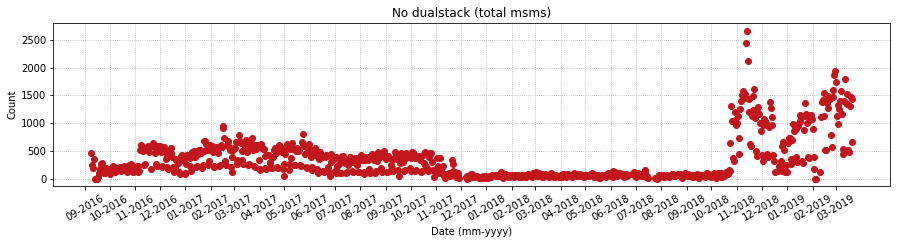

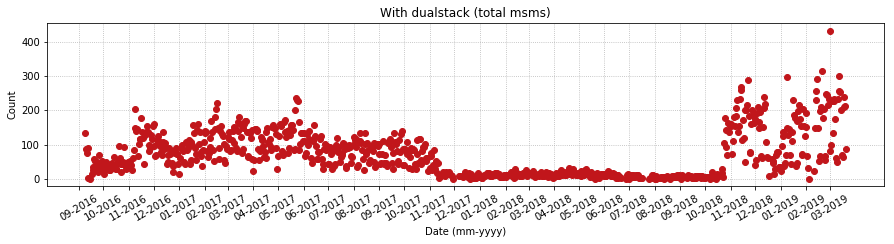

In [4]:
urls = ["/dualstack_false", "/dualstack_true"]
titles = ["No dualstack (total msms)", "With dualstack (total msms)"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## Dualstack ratio

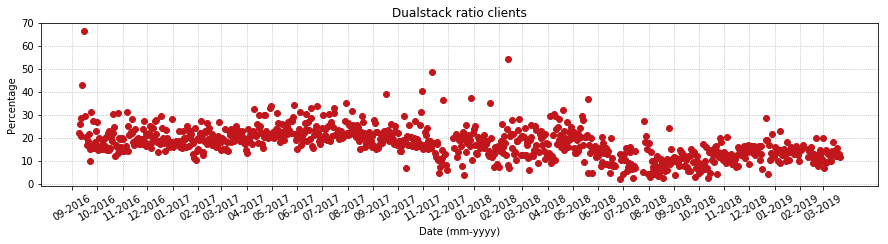

In [5]:
chart = {}

for k,v in answers["/dualstack_true"].items():
    ratio = 100.0*v / (answers["/dualstack_false"][k] + v)
    chart[k] = ratio

plot(
    chart.keys(), chart.values(), title="Dualstack ratio clients", ylabel="Percentage"
)

## NAT (any)

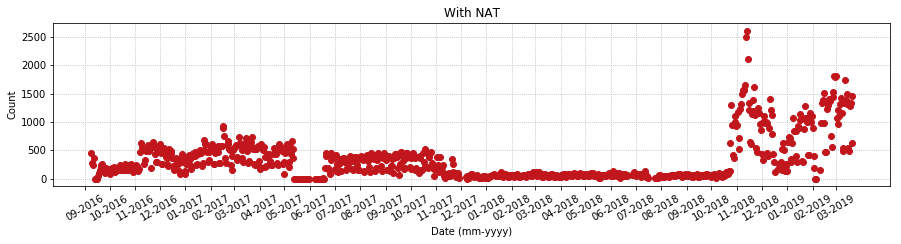

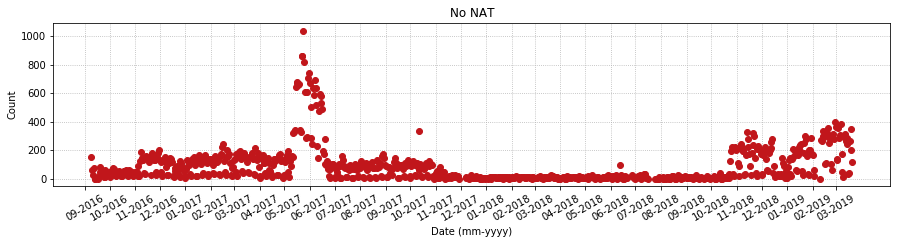

In [10]:
# plotting
urls = ["/nat_free_0_false", "/nat_free_0_true"]
titles = ["With NAT", "No NAT"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT (any) ratio

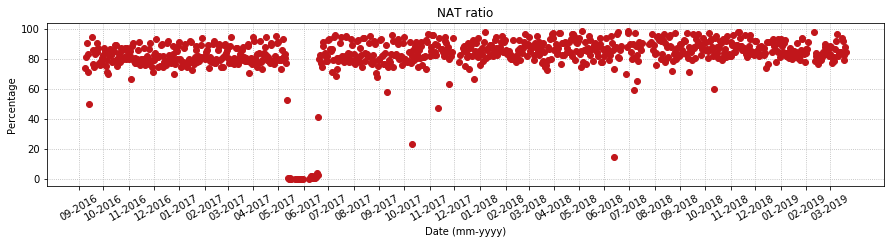

In [11]:
chart = {}

for k,v in answers["/nat_free_0_false"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_0_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT ratio", ylabel="Percentage"
)

## NAT 66

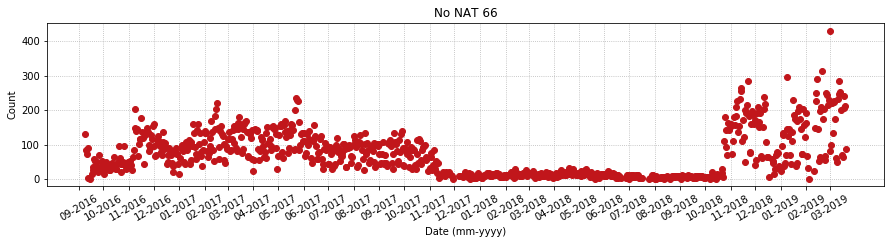

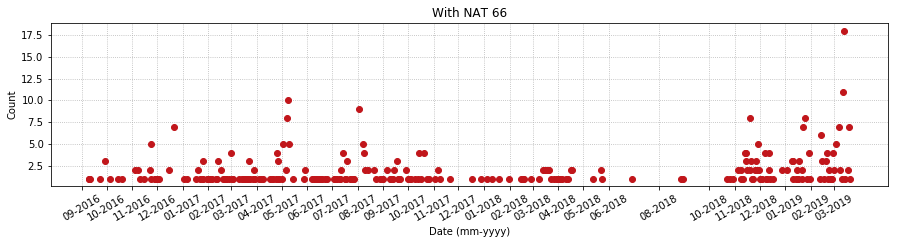

In [12]:
# plotting
urls = ["/nat_free_6_true", "/nat_free_6_false"]
titles = ["No NAT 66", "With NAT 66"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT 66 ratio

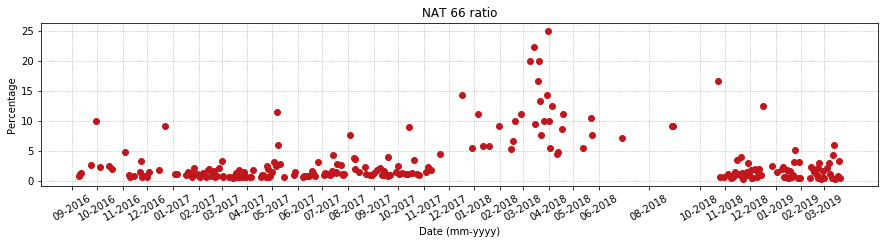

In [13]:
chart = {}

for k,v in answers["/nat_free_6_false"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_6_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT 66 ratio", ylabel="Percentage"
)

## NAT 44

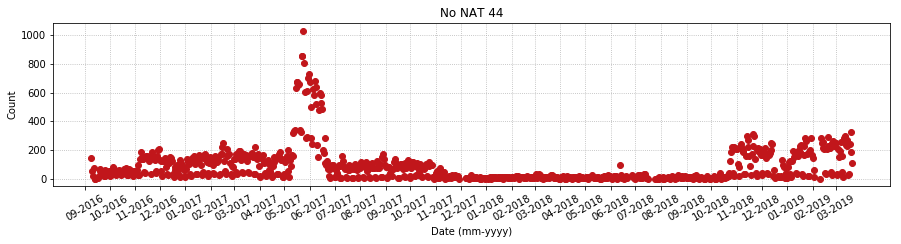

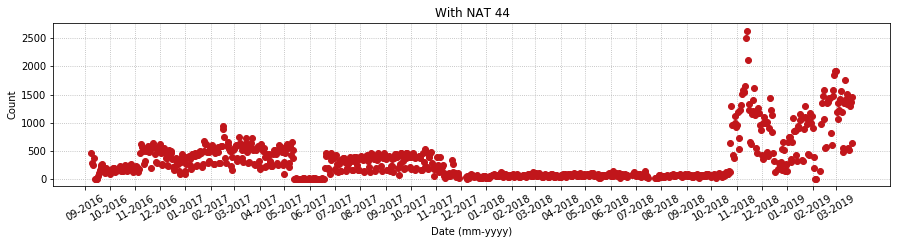

In [14]:
# plotting
urls = ["/nat_free_4_true", "/nat_free_4_false"]
titles = ["No NAT 44", "With NAT 44"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT 44 ratio

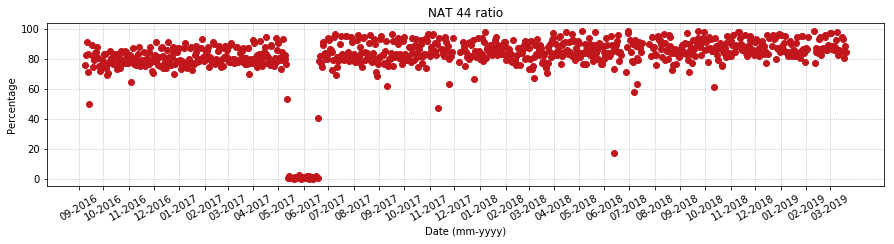

In [15]:
chart = {}

for k,v in answers["/nat_free_4_false"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_4_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT 44 ratio", ylabel="Percentage"
)

## v6-only

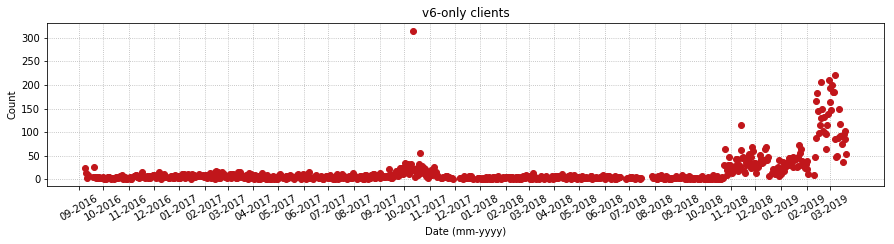

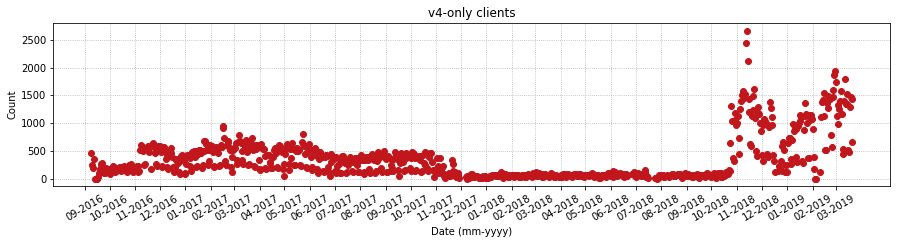

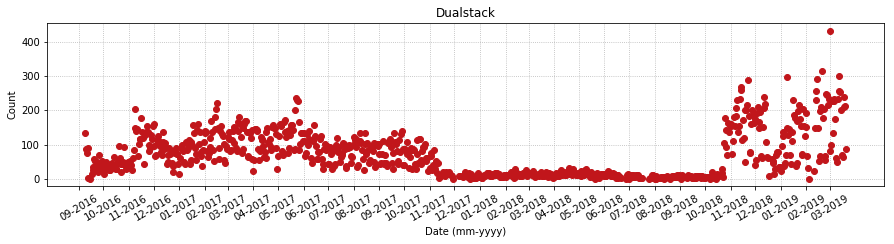

In [16]:
# plotting
urls = ["/v6_only", "/v4_only", "/dualstack_true"]
titles = ["v6-only clients", "v4-only clients", "Dualstack"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

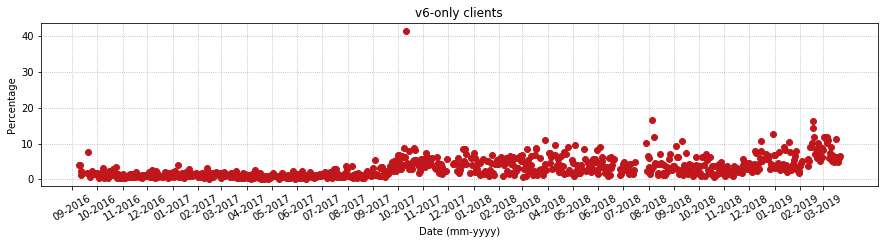

In [17]:
chart = {}

for k,v in answers["/v6_only"].items():
    try:
        ratio = 100.0*v / (answers["/v4_only"][k] + answers["/dualstack_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="v6-only clients", ylabel="Percentage"
)

## Network diversity: how many prefixes and ASNs are we reaching?

In [18]:
url = "https://natmeter.labs.lacnic.net/static/results.csv"

In [19]:
response = requests.get(url)

In [20]:
import json
from collections import Counter, defaultdict
from datetime import timedelta

dates = []
entries = response.text.split("\n")
date2pfxs = defaultdict(list)
date2asns = defaultdict(list)

for e in entries:
    if '#' in e or '\n' == e or '\r' == e:
        continue
    
    # headers
    if '[' not in e:
        continue
    
    e = e.replace('\'', '')
    
    private, public, asns, date = e.split('\t')
    private = private.replace('[', '').replace(']', '').decode('utf-8').split(', ')
    public = public.replace('[', '').replace(']', '').decode('utf-8').split(', ')
    asns = asns.replace('[', '').replace(']', '').decode('utf-8').split(', ')
    date = date.replace('\r', '')
    
    date = datetime.strptime(date, '%Y-%m-%d')
    
    dates.append(date)
    date2pfxs[date] += public
    date2asns[date] += asns
    

### Unique prefix count

In [21]:
start = min(date2pfxs.keys())
end = max(date2pfxs.keys())

current = start
delta = timedelta(days=90)

timeseries = defaultdict(datetime)
while current <= end:
    w_pfxs = [p for d,p in date2pfxs.items() if current-delta < d <= current]
    w_pfxs = [item for sublist in w_pfxs for item in sublist]

    w_unique_pfxs = len(set(Counter(w_pfxs)))
    timeseries[current] = w_unique_pfxs
    
    current += timedelta(days=1)

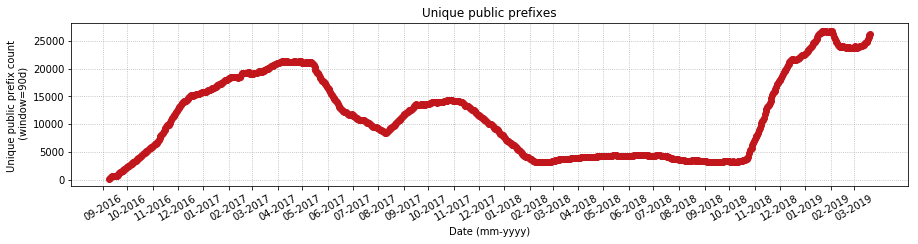

In [22]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="Unique public prefixes",
    ylabel="Unique public prefix count \n (window=90d)"
)

### Unique ASN count

In [23]:
start = min(date2asns.keys())
end = max(date2asns.keys())

current = start
delta = timedelta(days=90)

timeseries = defaultdict(datetime)
while current <= end:
    w_pfxs = [p for d,p in date2asns.items() if current-delta < d <= current]
    w_pfxs = [item for sublist in w_pfxs for item in sublist]

    w_unique_pfxs = len(set(Counter(w_pfxs)))
    timeseries[current] = w_unique_pfxs
    
    current += timedelta(days=1)

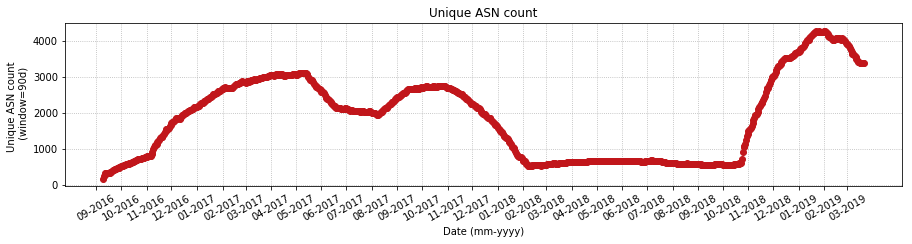

In [24]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="Unique ASN count",
    ylabel="Unique ASN count \n (window=90d)"
)

In [25]:
entries = response.text.split("\n")
date2nat = defaultdict(list)
date2nonat = defaultdict(list)
stats = {
    'nat':0,
    'no-nat':0
}

for e in entries:
    if '#' in e or '\n' == e or '\r' == e:
        continue
    
    # headers
    if '[' not in e:
        continue
    
    e = e.replace('\'', '')
    
    private, public, asns, date = e.split('\t')
    private = [pfx for pfx in private.replace('[', '').replace(']', '').decode('utf-8').split(', ') if pfx!='']
    public = [pfx for pfx in public.replace('[', '').replace(']', '').decode('utf-8').split(', ') if pfx!='']
    asns = [int(asn) for asn in asns.replace('[', '').replace(']', '').decode('utf-8').split(', ') if asn!='']
    date = date.replace('\r', '')
    
    date = datetime.strptime(date, '%Y-%m-%d')
    
    if len(asns)==0:
        continue
    
    if len(private)==0:
        stats['no-nat'] += 1
        date2nonat[date] += asns
    else:
        stats['nat'] += 1
        date2nat[date] += asns

### Measurements

In [26]:
100.0*stats['nat'] / (stats['nat']+stats['no-nat'])

98.09111957291287

### ASNs

In [27]:
networks_natted = set([i for l in date2nat.values() for i in l])
networks_not_natted = set([i for l in date2nonat.values() for i in l])

In [28]:
100.0*len(networks_natted) / (len(networks_natted)+len(networks_not_natted))

91.20044052863436

In [29]:
len(networks_natted.intersection(networks_not_natted))

702

In [30]:
len(networks_natted.difference(networks_not_natted))

7579

In [31]:
len(networks_not_natted.difference(networks_natted))

97

In [32]:
start = min(date2nat.keys())
end = max(date2nat.keys())

current = start
delta = timedelta(days=90)

timeseries = defaultdict(datetime)
while current <= end:
    w_pfxs = [p for d,p in date2nat.items() if current-delta < d <= current]
    w_pfxs = [item for sublist in w_pfxs for item in sublist]

    w_unique_pfxs = len(set(Counter(w_pfxs)))
    timeseries[current] = w_unique_pfxs
    
    current += timedelta(days=1)

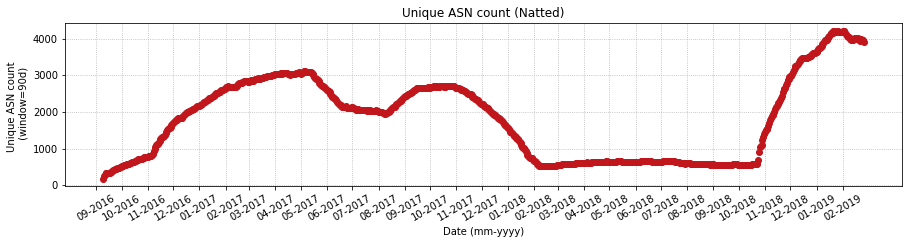

In [33]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="Unique ASN count (Natted)",
    ylabel="Unique ASN count \n (window=90d)"
)

In [34]:
start = min(date2nonat.keys())
end = max(date2nonat.keys())

current = start
delta = timedelta(days=90)

timeseries = defaultdict(datetime)
while current <= end:
    w_pfxs = [p for d,p in date2nonat.items() if current-delta < d <= current]
    w_pfxs = [item for sublist in w_pfxs for item in sublist]

    w_unique_pfxs = len(set(Counter(w_pfxs)))
    timeseries[current] = w_unique_pfxs
    
    current += timedelta(days=1)

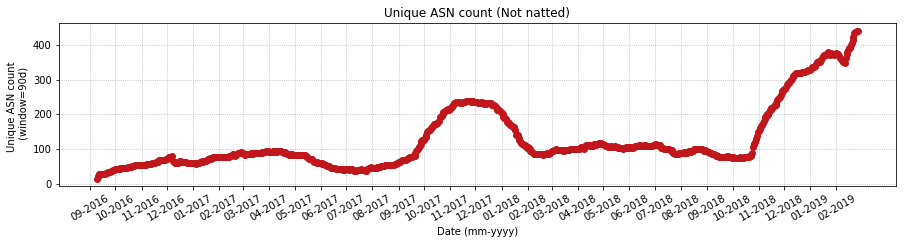

In [35]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="Unique ASN count (Not natted)",
    ylabel="Unique ASN count \n (window=90d)"
)

In [36]:
dates = set(date2nat.keys()).intersection(set(date2nonat.keys()))
start = min(dates)
end = max(dates)

current = start
delta = timedelta(days=90)

timeseries_natted_ratio = defaultdict(datetime)
timeseries_asns_doing_both = defaultdict(datetime)  # ASNs doing nat and no-nat
timeseries_asns_doing_nonat_only = defaultdict(datetime)  # ASNs doing nat and no-nat
timeseries_asns_doing_nat_only = defaultdict(datetime)  # ASNs doing nat and no-nat

while current <= end:
    natted_asns = [p for d,p in date2nat.items() if current-delta < d <= current]
    natted_asns = [item for sublist in natted_asns for item in sublist]
    natted_asns = set(Counter(natted_asns))
    
    not_natted_asns = [p for d,p in date2nonat.items() if current-delta < d <= current]
    not_natted_asns = [item for sublist in not_natted_asns for item in sublist]
    not_natted_asns = set(Counter(not_natted_asns))

    natted_ratio = 1.0*len(natted_asns) / (len(natted_asns) + len(not_natted_asns))
    
    timeseries_asns_doing_both[current] = len(natted_asns.intersection(not_natted_asns))
    timeseries_asns_doing_nonat_only[current] = len(not_natted_asns.difference(natted_asns))
    timeseries_asns_doing_nat_only[current] = len(natted_asns.difference(not_natted_asns))
    timeseries_natted_ratio[current] = natted_ratio
    
    current += timedelta(days=1)

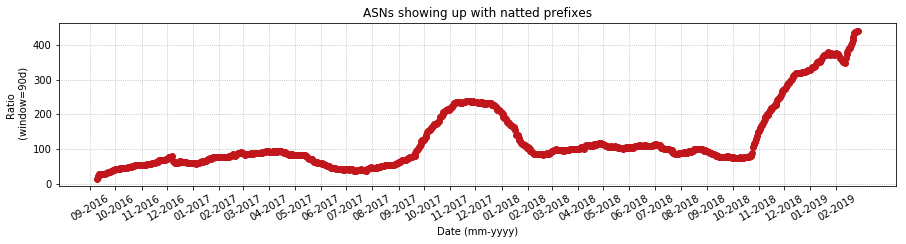

In [37]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="ASNs showing up with natted prefixes",
    ylabel="Ratio \n (window=90d)"
)

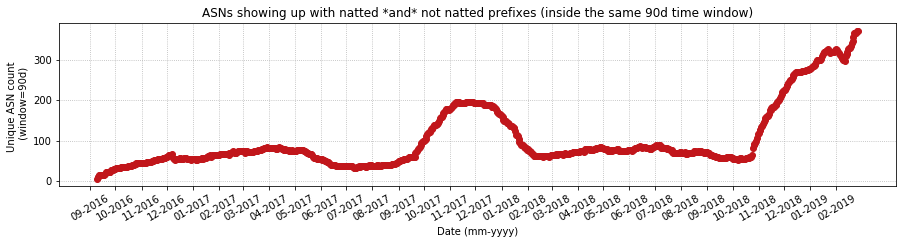

In [38]:
plot(
    timeseries_asns_doing_both.keys(),
    timeseries_asns_doing_both.values(),
    title="ASNs showing up with natted *and* not natted prefixes (inside the same 90d time window)",
    ylabel="Unique ASN count \n (window=90d)"
)

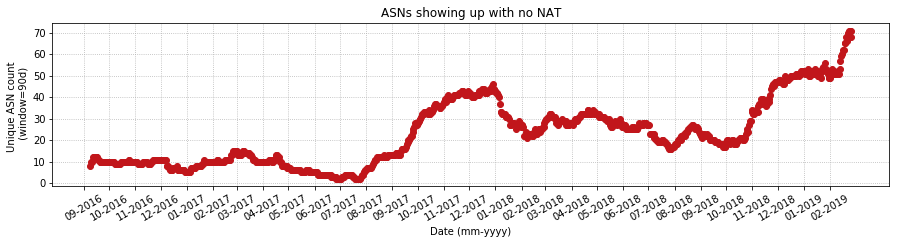

In [39]:
plot(
    timeseries_asns_doing_nonat_only.keys(),
    timeseries_asns_doing_nonat_only.values(),
    title="ASNs showing up with no NAT",
    ylabel="Unique ASN count \n (window=90d)"
)

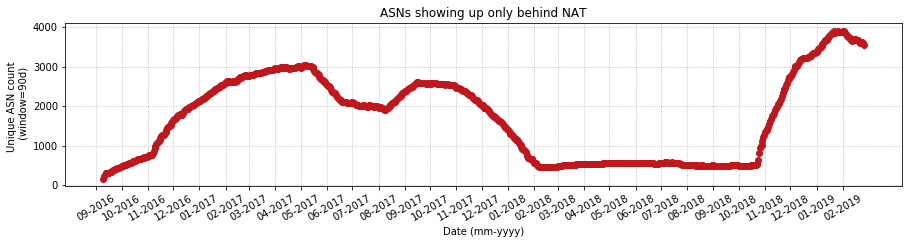

In [40]:
plot(
    timeseries_asns_doing_nat_only.keys(),
    timeseries_asns_doing_nat_only.values(),
    title="ASNs showing up only behind NAT",
    ylabel="Unique ASN count \n (window=90d)"
)